# **Image Retrieval: Face Attributes** 

**Course:** Deep Learning

**Students:** Giuseppe Marchesani - Giovanni Castoldi

# **Abstract** 
## Goal
Image retrieval refers to the process of finding images that are relevant to a given search query. Traditionally, this task has relied on metadata such as tags, annotations, or textual descriptions. However, more advanced systems perform retrieval based on the visual content of images themselves, enabling searches based on color, texture, shape, or even high-level semantic features.

In this project, we focus on implementing an attribute-based image retrieval system that can search for images of people based on a set of facial attributes. Each query is defined by a set of semantic attributes such as gender, hair color, or face shape. This problem naturally leads to a multimodal learning setting, where two different data types, images and their corresponding attribute vectors, must be aligned in a common representation space, allowing direct comparison between them.

## Problem formulation
Let x$_{i}$ denote an image and a$_{i}$ ∈ {0, 1} $^{40}$ its corresponding attribute vector. The goal is to learn two embedding functions:
*  $f$$_{I}$$(x)$: an image embedding function,
*  $f$$_{A}$$(a)$: an attribute embedding function.
  
Both functions map their inputs into a shared D-dimensional embedding space, with D = 300
in our implementation.

In this space, distances directly reflect semantic similarity:
* embeddings of images should be close to embeddings of their correct attribute vectors,
* embeddings of images should be far from embeddings of incorrect attribute vectors.


## Implementation
To address the objective of attribute-based face image retrieval, we employed a deep metric learning framework with weak supervision, combining:
* a **Convolutional Neural Network - (CNN)** that generates embeddings from images
* a **Fully-Connected Neural Network (MLP)** that generates embeddings from attribute vectors.
  
For the image modality, we adopt a transfer learning strategy using a convolutional neural network pretrained on ImageNet (ResNet50) as a feature extractor, followed by a custom head that maps these features into the embedding space.\
In parallel, the attribute branch is implemented as a multilayer perceptron (MLP) composed of fully connected layers with non-linear activations.\
\
As a training strategy, we kept frozen the backbone of the image network, while we trained the embedding head from scratch using a weak supervision approach based on a batch-all triplet loss formulation. For each image embedding (anchor), the corresponding attribute embedding is treated as the positive, while other attribute embeddings in the batch serve as negatives.
Both image and attribute embeddings are learned jointly so that semantically corresponding images and attribute descriptions are close to each other, while mismatched pairs are pushed apart. 

After training, image retrieval is performed by embedding a query attribute vector and ranking all images in the retrieval set according to their similarity in the learned embedding space. This enables effective and flexible image retrieval based solely on semantic attribute queries.

## Results
We learned a shared multimodal embedding space that enables effective retrieval from
semantic queries.\
Qualitative retrieval results show that the system retrieves visually coherent images that respect the queried attributes. The system performs well on prominent attributes such as gender and hair color, and the introduction of hard negatives significantly improved performance on subtle attributes such as eyeglasses.\
While the proposed system demonstrates strong performance, some limitations remain. Rare
attributes suffer from data imbalance, and very fine visual details (e.g. moustaches) may require partial fine-tuning of the backbone. Additionally, attribute annotations may contain noise, limiting the maximum achievable performance.


# Setup, imports and device

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from torchvision.datasets import CelebA
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

import glob
import subprocess
import textwrap
import importlib 

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Detect Kaggle ---
ON_KAGGLE = "KAGGLE_URL_BASE" in os.environ

# --- Detect Colab ---
ON_COLAB = False
if importlib.util.find_spec("google.colab") is not None:
    ON_COLAB = True

# If we are on both (happens rarely), Kaggle takes priority.
if ON_KAGGLE:
    ON_COLAB = False

print("On Kaggle:", ON_KAGGLE)
print("On Colab:", ON_COLAB)

Device: cuda
On Kaggle: True
On Colab: False
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Loading the dataset

We use the CelebA dataset, which consists of face images annotated with 40 binary attributes
describing various facial characteristics such as gender, hair color, accessories, and others...\
\
The dataset is split into three disjoint subsets:
* **Training set** - [162770 images]: used to learn the model parameters.
* **Validation set** - [19867 images]: used to monitor training and tune hyperparameters.
* **Test set** - [19962 images]: used exclusively for final evaluation and retrieval experiments.

All retrieval experiments and reported metrics are computed on the test set to ensure a fair
evaluation of the model’s generalization capability.

### Dataset Access Instructions
As requested, the dataset is not included directly in the submission.\
Instead, the notebook provides a fully automatic and environment-aware loading procedure, ensuring that the CelebA dataset can be obtained easily on any platform.

There are two supported ways to obtain the data:
1. **Using the CelebA dataset from Kaggle**\
   If the notebook is executed on Kaggle, simply attach the official “CelebA Dataset” as an input dataset. \
   Download the images from this link: https://github.com/jhalmes/celeba \
   Download the annotations from this link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg&amp%3Busp=sharing \
   and then recreate the following structure in ***/kaggle/input/celeba/*** folder:\
   celeba\
├── img_align_celeba\
│   ├── 000001.jpg\
│   ├── 000002.jpg\
│   └── ...\
├── identity_CelebA.txt\
├── list_attr_celeba.txt\
├── list_bbox_celeba.txt\
├── list_eval_partition.txt\
└── list_landmarks_align_celeba.txt

   The notebook automatically detects the Kaggle environment and loads the dataset from:
   ***/kaggle/input/celeba/***
   
3. **Using the CelebA dataset via TorchVision (Colab or local)**\
   If the notebook is executed on Google Colab or on a local machine, the dataset is automatically downloaded through:\
   ***torchvision.datasets.CelebA(..., download=True)***


The notebook will store the downloaded files in:
* /content/celeba/ on Colab
* ./data/celeba/ when run locally
so that the dataset is only downloaded once.

In [3]:
# --- Dataset root selection (Kaggle vs Colab vs local) ---

if ON_KAGGLE:
    print("\nRunning on Kaggle.")

    DATASET_DIR = "/kaggle/input/celeba"      # read-only input
    CELEBA_ROOT = "/kaggle/working/celeba"    # writable copy

    if not os.path.exists(DATASET_DIR):
        raise RuntimeError(
            "CelebA dataset is not attached as a Kaggle input. "
            "Please add the 'celeba' dataset in the Kaggle UI."
        )

    os.makedirs(CELEBA_ROOT, exist_ok=True)

    # Sync from read-only input to working directory (once)
    print(f"Syncing CelebA from {DATASET_DIR} to {CELEBA_ROOT} ...")
    subprocess.run(
        ["rsync", "-a", "--info=progress2", DATASET_DIR + "/", CELEBA_ROOT + "/"],
        check=True
    )

else:
    print("\nNot running on Kaggle – using torchvision download.")

    # Choose a reasonable root depending on environment
    if ON_COLAB:
        base_dir = "/content"
    else:
        base_dir = os.path.join(os.getcwd(), "data")

    CELEBA_ROOT = os.path.join(base_dir, "celeba")
    os.makedirs(CELEBA_ROOT, exist_ok=True)

print("CELEBA_ROOT =", CELEBA_ROOT)



Running on Kaggle.
Syncing CelebA from /kaggle/input/celeba to /kaggle/working/celeba ...
  1,461,079,120 100%    2.19MB/s    0:10:35 (xfr#202604, to-chk=0/202607)     
CELEBA_ROOT = /kaggle/working/celeba


In [4]:
# --- Load CelebA (download automatically if needed, except on Kaggle) ---

root = CELEBA_ROOT

# On Kaggle we assume the dataset is already present (no internet),
# on Colab/local we allow torchvision to download it the first time.
download_flag = not ON_KAGGLE

print("\nLoading CelebA dataset...")
print("Root:", root)
print("download =", download_flag)

train_set = CelebA(root=root, split="train", target_type="attr", download=download_flag)
val_set   = CelebA(root=root, split="valid", target_type="attr", download=download_flag)
test_set  = CelebA(root=root, split="test",  target_type="attr", download=download_flag)

# Number of attributes and their names
A = train_set.attr.shape[1]
attr_names = train_set.attr_names

print("\nTrain/Val/Test sizes:", len(train_set), len(val_set), len(test_set))
print("Number of attributes (A):", A)
print("CelebA dataset is ready.")



Loading CelebA dataset...
Root: /kaggle/working/celeba
download = False

Train/Val/Test sizes: 162770 19867 19962
Number of attributes (A): 40
CelebA dataset is ready.


In [5]:
train_set

Dataset CelebA
    Number of datapoints: 162770
    Root location: /kaggle/working/celeba
    Target type: ['attr']
    Split: train

### Understanding the dataset
Each sample in the dataset is a tuple containing the image and the attributes. Attributes are encoded as a 40-dimensional multi-hot vector, where each element is either 0 or 1 indicating the absence or presence of the corresponding attribute.

In [6]:
image, attributes = train_set[0]

print(image, '\n')
print(attributes)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7DDCB6B07DD0> 

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])


### Plotting some samples

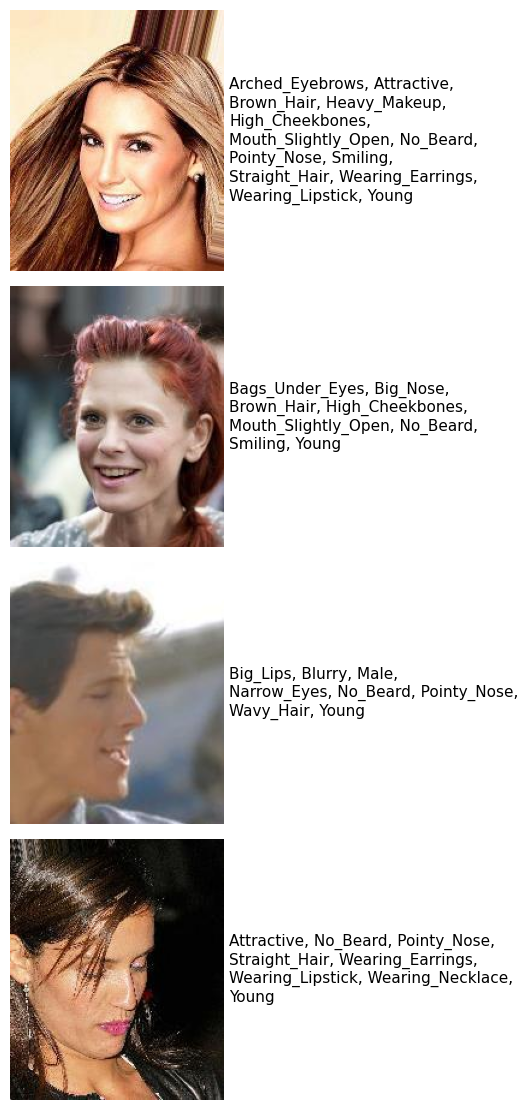

In [7]:
import textwrap

def show_samples(ds, n=4):
    fig, axes = plt.subplots(n, 2, figsize=(6, 2.8*n), tight_layout=True)
    for i in range(n):
        img, attr = ds[i]
        active = [ds.attr_names[j] for j in range(len(attr)) if attr[j].item() == 1]
        axes[i,0].imshow(img); axes[i,0].axis("off")
        axes[i,1].text(0, 0.5, "\n".join(textwrap.wrap(", ".join(active), width=35)),
                       fontsize=11, va="center")
        axes[i,1].axis("off")
    plt.show()

show_samples(train_set, n=4)

# Architecture

The architecture consists of two separate neural networks:
*   A **Convolutional Neural Network (CNN)** that generates embeddings from images formed by:
    *   a pre-trained backbone (ResNet50) for feature extraction,
    *   a custom-head that maps these features into the 300-dimensions embedding space.
*   A **Fully-Connected Neural Network (MLP)** that generates embedding from attribute vectors:\
two linear layers (each with 300 dimensions) interleaved with batch normalization and ReLU activation function to introduce non-linearity.

Both networks will produce outputs in **the same embedding space** to allow direct comparison between images and attributes.

## CNN

For the image modality, we adopted a transfer learning strategy: a convolutional neural network
pretrained on ResNet50 is our backbone and it is used as a feature extractor.

The expected input is a tensor with shape: [B, 3, 224, 224], where:
* B is the batch size,
* 3 is the channel size (RGB images),
* 224x224 is for the image height and width.

The backbone network outputs a 2048-dimensional feature vector for each image: [B, 2048].

### Backbone

In [8]:
weights = ResNet50_Weights.DEFAULT

# Before a pre-trained model can be used to make predictions, we must preprocess the input images (resize with the right resolution, rescale the values, etc).
# A pretrained network expects images normalized exactly like it was trained.
preprocess = weights.transforms()

backbone = resnet50(weights=weights)

# ResNet50 normally ends with a classifier layer.
# We don’t want class logits. We want the 2048 vector before classification.
# We remove the classificator head. So, the backbone output becomes the 2048D features vector.
backbone.fc = nn.Identity()

#Some models use layers which have different training and evaluation behavior, such as batch normalization. 
#To switch between these modes, we must use model.train() or model.eval() as appropriate.
backbone.eval().to(device)

#Freezing the gradient (and so the weights: the network is pre-trained)
for p in backbone.parameters():
    p.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 


### Data transformation
TorchVision CelebA returns a PIL image, untransformed.
But the backbone needs tensors properly transformed.
So, we wrap CelebA with a transform.


In [10]:
class CelebAWithTransforms(torch.utils.data.Dataset):

    def __init__(self, base_ds, transform):
        self.base = base_ds
        self.transform = transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, attr = self.base[idx]  #PIL, Tensor [40]
        img = self.transform(img)
        attr = attr.float()

        # Some torchvision versions store attrs as {-1, +1}. Convert to {0,1} if needed:
        if attr.min() < 0:
            attr = (attr + 1.0) / 2.0
        return img, attr

### Features extraction
We loop through the dataset with a dataloader.
For each batch of images and attributes:

*   We extract the image features using the pre-trained model.
*   We store on the CPU the image features and attributes in two separate lists.

At the end of the loop, we stack the image features and attributes into tensors:
* feats: [B, 2048]
* attrs: [B, 40]

In [12]:
@torch.no_grad()
def extract_features(base_ds, batch_size=128, num_workers=2):
    
    ds = CelebAWithTransforms(base_ds, preprocess)
    
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=(device.type == "cuda")
    )

    feats, attrs = [], []
    backbone.eval()
    for x, a in loader:
        x = x.to(device, non_blocking=True)
        f = backbone(x)            # [B, 2048]
        feats.append(f.cpu())
        attrs.append(a.cpu())

    return torch.cat(feats, 0), torch.cat(attrs, 0)

### Load or extract features

In [14]:
# 1) Decide where features are stored
if ON_KAGGLE:
    features_save_dir = "/kaggle/working/celeba_processed_features"
else:
    # On Colab/local, put them next to the dataset
    features_save_dir = os.path.join(CELEBA_ROOT, "celeba_processed_features")

os.makedirs(features_save_dir, exist_ok=True)
print("Features directory:", features_save_dir)

train_path = os.path.join(features_save_dir, "train_feats_attrs.pt")
val_path   = os.path.join(features_save_dir, "val_feats_attrs.pt")
test_path  = os.path.join(features_save_dir, "test_feats_attrs.pt")

# 2) Check if all .pt files already exist
all_exist = all(os.path.exists(p) for p in [train_path, val_path, test_path])

if all_exist:
    print("\n>>> Loading precomputed features...")

    train_feats, train_attrs = torch.load(train_path, map_location=device)
    val_feats,   val_attrs   = torch.load(val_path,   map_location=device)
    test_feats,  test_attrs  = torch.load(test_path,  map_location=device)

else:
    print("\n>>> Feature files not found. Extracting features with ResNet-50...")

    # Extract features for each split
    train_feats, train_attrs = extract_features(train_set, batch_size=128)
    val_feats,   val_attrs   = extract_features(val_set,   batch_size=128)
    test_feats,  test_attrs  = extract_features(test_set,  batch_size=128)

    print("Train:", train_feats.shape, train_attrs.shape)
    print("Val:  ", val_feats.shape,   val_attrs.shape)
    print("Test: ", test_feats.shape,  test_attrs.shape)

    # Save to disk (Kaggle / Colab / local)
    torch.save((train_feats, train_attrs), train_path)
    torch.save((val_feats,   val_attrs),   val_path)
    torch.save((test_feats,  test_attrs),  test_path)

    print("Saved feature files to:", features_save_dir)

# 3) Make sure attrs are float {0,1}
train_attrs = train_attrs.float()
val_attrs   = val_attrs.float()
test_attrs  = test_attrs.float()

print("\nFeature shapes:")
print("  train_feats:", train_feats.shape, "train_attrs:", train_attrs.shape)
print("  val_feats:  ", val_feats.shape,   val_attrs.shape)
print("  test_feats: ", test_feats.shape,  test_attrs.shape)

# 4) DataLoaders
BATCH_SIZE = 256

train_loader = DataLoader(
    TensorDataset(train_feats, train_attrs),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(val_feats, val_attrs),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    TensorDataset(test_feats, test_attrs),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\nDataLoaders are ready.")

Features directory: /kaggle/working/celeba_processed_features

>>> Loading precomputed features...

Feature shapes:
  train_feats: torch.Size([162770, 2048]) train_attrs: torch.Size([162770, 40])
  val_feats:   torch.Size([19867, 2048]) torch.Size([19867, 40])
  test_feats:  torch.Size([19962, 2048]) torch.Size([19962, 40])

DataLoaders are ready.


### **ImageHead**

The backbone produces 2048 numbers for each image and 40 numbers for the associated attributes. They are not comparable: we need the definition of the two final encoders that produce image embeddings.

On top of the backbone, we add an image embedding head consisting of a fully connected
layer mapping the 2048-dimensional features to a 300-dimensional embedding, followed by L2
normalization. \
\
The Image Head receive as input the backbone feature [B, 2048] and produces as output the image embedding [B, 300].

In [15]:
D = 300

class ImageHead(nn.Module):
    def __init__(self, in_dim=2048, out_dim=D):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        z = self.fc(x)
        z = F.normalize(z, p=2, dim=1)
        return z

img_head = ImageHead(2048, D).to(device)

## **MLP**

A Fully-Connected Neural Network that generates embedding from attribute vectors.\
It takes a 40-dimensional binary attribute vector [B, 40] as input and outputs a 300-dimensional embedding [B, 300]. The network includes:
* an input linear layer,
* a non-linear activation,
* an output linear layer,
* L2 normalization of the output.


Images and attributes are now comparable since they live in the same embedding space (300-dimensional).




In [16]:
class AttrMLP(nn.Module):
    def __init__(self, in_dim=40, hidden=300, out_dim=300):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, a):
        z = self.net(a)
        z = F.normalize(z, p=2, dim=1)
        return z

attr_mlp = AttrMLP(A, D, D).to(device)

# Training

## Weakly Supervised Triplet Loss
The embeddings of an image should be close to the embeddings of its correct attribute vector, while being far from the embeddings of incorrect attribute vectors. To accomplish this, we train the networks using a **triplet loss function** that takes the following inputs:

* *Anchor*   -> the embedding of an image.
* *Positive* -> the embedding of the attribute vector associated with the anchor image.
* *Negative* -> the embedding of an attribute vector that does not match the anchor image.

In [17]:
class WeakTripletLossBatchAll_ImageAnchor(nn.Module):

    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, img_emb, attr_emb, attr_bin=None):
        B = img_emb.size(0)

        # Distance matrix between all image-attributes pairs
        # dist[i,j] = distance( image_i , attr_j )
        # Row i tells how much image i is far from all the attributes vectors of the batch
        dist = torch.cdist(img_emb, attr_emb, p=2)  # Final shape: (B,B)

        # Positives are aligned on the diagonal, so dist.diag() extracts dist[0,0], dist[1,1], ..., dist[B-1,B-1].
        # The right pair is indeed (i,i).
        # d_pos is a B-length vector
        d_pos = dist.diag()  # (B,)

        # Copy dist and transform it into a matrix of negative distances candidates
        # Negatives = all off-diagonal entries
        neg_dist = dist.clone()
        # Mask diagonal (positive is not a negative)
        diag_mask = torch.eye(B, dtype=torch.bool, device=dist.device) # Torch.eye creates an identity BxB matrix, True value on the diagonal
        neg_dist.masked_fill_(diag_mask, float("inf"))
        # Result: dist[i,i] = "inf"

        # Mask identical attribute vectors (avoid false negatives)
        if attr_bin is not None:
            a_bool = attr_bin.bool()
            same_attr = (a_bool.unsqueeze(1) == a_bool.unsqueeze(0)).all(dim=2)  # (B,B)
            neg_dist.masked_fill_(same_attr, float("inf"))

        # Triplet loss for all negatives: max(0, d_pos - d_neg + margin)
        # For each anchor i and for each negative candidate j, build: l_ij = d_pos(i) - d_neg(i,j) + margin
        loss_mat = d_pos.unsqueeze(1) - neg_dist + self.margin  # (B,B)

        # Equivalent to ReLU(loss_mat) and the ignoring zeros
        # Only triplet that violate margin are kept. They produce gradient and make the model learns.
        hard = loss_mat[loss_mat > 0]  # keep hard/semi-hard

        if hard.numel() == 0:
            return torch.tensor(0.0, device=dist.device)

        return hard.mean() #


## Hard Negatives and Optimization
To improve performance on subtle attributes, we introduce hard negatives. \
Hard negatives are generated by modifying the correct attribute vector by flipping a small number of attributes (1-3). These modified vectors are semantically close to the positive but incorrect, making them difficult negatives.
An additional loss term enforces that image embeddings remain farther from these hard negatives than from the correct attribute embeddings. \
This strategy prevents premature convergence and encourages the model to learn fine-grained semantic distinctions.

Training is performed using the Adam optimizer with a learning rate of 10$^{−3}$ and weight decay. Training and validation losses decrease smoothly and remain close throughout training, indicating stable optimization and good generalization.


In [18]:
loss_fn = WeakTripletLossBatchAll_ImageAnchor(margin=0.5).to(device) #d(img, attr_pos) + 0.5 < d(img, attr_neg)

optimizer = torch.optim.Adam(list(img_head.parameters()) + list(attr_mlp.parameters()), lr=1e-3, weight_decay=1e-5)

def create_hard_negatives(attributes: torch.Tensor,
                          hard_count: int,
                          max_flips: int = 3) -> torch.Tensor:
    """
    attributes : (B, A) tensor with values in {0,1}
    returns    : (B, hard_count, A) tensor
    """
    # (B, 1, A) -> (B, H, A) - insert a dimension and replicate along that dimension
    hard_negatives = attributes.unsqueeze(1).repeat(1, hard_count, 1).bool()
    B, H, A = hard_negatives.shape

    # random permutation of attributes
    rand_perm = torch.rand(B, H, A, device=attributes.device).argsort(dim=2)

    # how many attributes to flip (1..max_flips)
    num_flips = torch.randint(
        1, max_flips + 1, (B, H), device=attributes.device
    )

    for i in range(1, max_flips + 1):
        mask = num_flips == i
        if not mask.any():
            continue

        selected = rand_perm[:, :, :i]
        b_idx, h_idx = torch.nonzero(mask, as_tuple=True)
        attr_idx = selected[b_idx, h_idx]

        # flip 0<->1
        hard_negatives[
            b_idx.unsqueeze(1),
            h_idx.unsqueeze(1),
            attr_idx
        ] ^= True

    return hard_negatives.float()

def run_epoch(loader, train=True, hard_count=4,
              hard_weight=0.5):
    if train:
        img_head.train(); attr_mlp.train()
    else:
        img_head.eval(); attr_mlp.eval()

    total_loss = 0.0
    n_batches = 0

    for img_feats_b, attrs_b in loader:
        # (if you didn't move full tensors to device, do it here)
        img_feats_b = img_feats_b.to(device)
        attrs_b     = attrs_b.to(device)

        # Forward: embeddings
        img_emb  = img_head(img_feats_b)   # (B,D)  anchor
        attr_emb = attr_mlp(attrs_b)       # (B,D)  pos/neg pool

        loss_base = loss_fn(img_emb, attr_emb, attr_bin=attrs_b)

        hard_attrs = create_hard_negatives(
            attrs_b,
            hard_count=hard_count,
            max_flips=3
        )                                   # (B, H, A)

        B, H, A = hard_attrs.shape

        # 2) embed them
        hard_attr_emb = attr_mlp(
            hard_attrs.view(B * H, A)
        ).view(B, H, -1)                    # (B, H, D)

        # 3) distances
        d_pos = (img_emb - attr_emb).pow(2).sum(dim=1)          # (B,)
        d_neg = (img_emb.unsqueeze(1) - hard_attr_emb)\
                    .pow(2).sum(dim=2)                          # (B,H)

        # 4) hard triplet loss
        loss_hard = torch.relu(
            d_pos.unsqueeze(1) - d_neg + loss_fn.margin
        ).mean()

        # ======================
        # TOTAL LOSS
        # ======================
        loss = loss_base + hard_weight * loss_hard

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(1, n_batches)

history = {"train_loss": [], "val_loss": []}

EPOCHS = 10
for epoch in range(EPOCHS):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr)
    history["val_loss"].append(va)
    print(f"Epoch {epoch+1:02d} | train_loss={tr:.4f} | val_loss={va:.4f}")


Epoch 01 | train_loss=0.3415 | val_loss=0.3204
Epoch 02 | train_loss=0.3115 | val_loss=0.3146
Epoch 03 | train_loss=0.3060 | val_loss=0.3113
Epoch 04 | train_loss=0.3032 | val_loss=0.3129
Epoch 05 | train_loss=0.3016 | val_loss=0.3103
Epoch 06 | train_loss=0.3001 | val_loss=0.3096
Epoch 07 | train_loss=0.2992 | val_loss=0.3090
Epoch 08 | train_loss=0.2985 | val_loss=0.3087
Epoch 09 | train_loss=0.2979 | val_loss=0.3095
Epoch 10 | train_loss=0.2969 | val_loss=0.3102


## Plotting Training vs Validation Loss

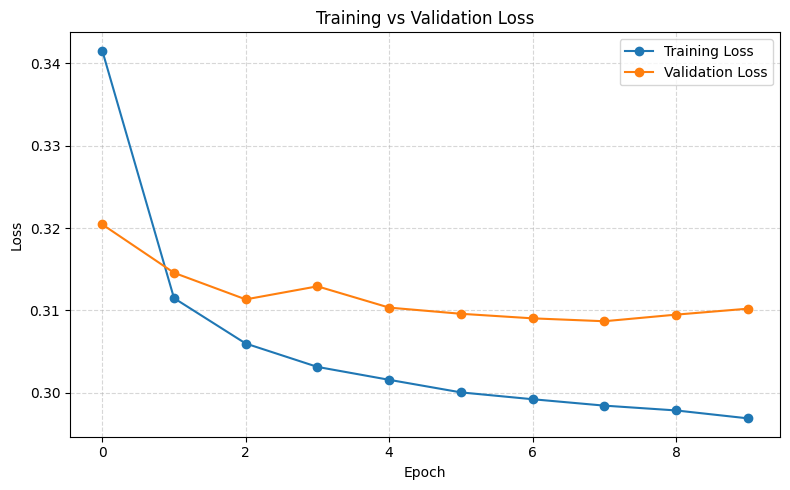

In [19]:
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Training Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The graph shows:
* training loss ≈ 0.297
* validation loss ≈ 0.308

Both learning curves decrease and then flatten.\
It is expected that such losses do not go to zero because Triplet Loss is zero only if every positive is perfectly closer than every negative by at least the margin for all pairs in the batch.

Such condition for a real dataset like CelebA, is impossible because:
* too many attributes overlap,
* some images are ambiguous,
* embeddings cannot satisfy all pairwise constraints.

Therefore we consider such results normal and healthy.

# Retrieval Pipeline


## Embeddings
### Image embeddings
Before performing attribute‑based retrieval, we must compute the embeddings for all images in the retrieval set (the test set).
This step is important because it allows us to avoid recomputing embeddings during each query: we compute them once, store them, and reuse them efficiently.

The image embeddings are obtained by:
1. Taking the pre‑computed 2048‑dimensional ResNet‑50 features
2. Passing them through the image embedding head (a fully connected layer + L2 normalization)
3. Producing a final embedding of dimension D = 300

All embeddings are normalized to lie on the unit hypersphere, which ensures consistent distance comparisons during retrieval.

The output is a tensor of shape: (num_images, D)
These embeddings represent the semantic content of each image and will be used for nearest‑neighbor search.

### Attribute query embeddings
To retrieve images for a given semantic query, we also define a function that embeds a single attribute vector using the attribute MLP.\
The vector is expanded to batch shape (1, 40) passed through the MLP, L2-normalized and returned as a (300, ) embedding.\
This allows direct comparison between the attribute query and every image embedding.

In [21]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def compute_image_embeddings(img_feats, batch_size=2048):
    img_head.eval() #Puts the model in inference mode (good practice).
    embs = []
    for i in range(0, img_feats.shape[0], batch_size):
        batch = img_feats[i:i+batch_size].to(device) #Moves that chunk to GPU/CPU where the model is
        emb = img_head(batch)          # These are the vectors you’ll compare during retrieval
        embs.append(emb.detach().cpu())
    return torch.cat(embs, dim=0)      # Final img_embs: shape (N, D) = embeddings for all retrieval images


@torch.no_grad()
def compute_attr_embedding(attr_vec): # Given a query attribute vector, retrieve the most similar images
    attr_mlp.eval()
    a = attr_vec.unsqueeze(0).to(device)    # Turns shape (40,) into (1, 40) because PyTorch Linear expects batches
    emb = attr_mlp(a).squeeze(0)            # (D,)
    return emb.detach().cpu()

# Choose your retrieval set (typically: test set)
"""
We use the test set for retrieval because:
Retrieval + metrics are an evaluation step, not a training step.
So we must evaluate on data the model has never seen during training.
"""
retrieval_feats = test_feats
retrieval_attrs = test_attrs   # (N, 40) in {0,1}

img_embs = compute_image_embeddings(retrieval_feats)  # (N, D)
print("img_embs:", img_embs.shape)
print("retrieval_attrs:", retrieval_attrs.shape)


img_embs: torch.Size([19962, 300])
retrieval_attrs: torch.Size([19962, 40])


## Ranking
Once we have computed all image embeddings in the retrieval set, the next step is to retrieve the images that best match a given attribute query.
This function performs the core retrieval operation by comparing the query attribute embedding with all image embeddings and selecting the most similar ones.

Since both the query embedding and image embeddings are L2-normalized, comparison is computed performing cosine similarity which reduces to a simple dot product that returns a vector of shape (N, ), where N is the number of images in the retrieval set.

We extract the indices of the K images with the highest similarity scores.\
These indices correspond to the retrieved images that best match the semantic attributes in the query.

In [22]:
@torch.no_grad()
def retrieve_topk(query_attr_vec, img_embs, k=10):
    q_emb = compute_attr_embedding(query_attr_vec)          # (D,)
    scores = img_embs @ q_emb                                # (N,) cosine similarity
    top = torch.topk(scores, k=k)
    return top.indices, top.values


# Evaluation

To evaluate the retrieval system, we need a systematic way to generate attribute‑based queries.
We create partial semantic queries by selecting only m attributes (m = 3) of a random chosen image.\
This simulates realistic user queries: people usually describe faces using a few attributes (e.g., Male, Blond Hair, Smiling), not complete 40‑dimensional annotations.

The output is therefore:
* idx: the selected attribute indices
* val: the desired values for those indices

These values are used both to construct a query, and evaluate which images are relevant to it.\
A relevant image is defined as one that matches all the selected m attributes with exactly the specified values (0 or 1).

In particular, to estimate average performance, we randomly sample several queries from the dataset (200 queries). For each query:

* Build a partial attribute query (m randomly selected attributes)
* Identify relevant images
* Rank all images by similarity
* Compute P@K, R@K, and AP
* Repeat and average the results


In [23]:
m = 3
# m = 3 is a design choice that controls how specific the query is.

def build_query_from_attrs(attr_vec, m=m):
    """
    attr_vec: (A,) 0/1
    returns: (indices, values)
    """
    A = attr_vec.numel()
    idx = torch.randperm(A)[:m]
    val = attr_vec[idx]
    return idx, val

"""
relevant_mask: produces a boolean array of length N:
-True = relevant image
-False = not relevant

This gives the “ground truth relevant set” for that query.
"""
def relevant_mask(retrieval_attrs, idx, val):
    """
    retrieval_attrs: (N, A)
    idx: (m,) indices of attributes
    val: (m,) desired values
    returns: (N,) bool mask
    """
    return (retrieval_attrs[:, idx] == val.unsqueeze(0)).all(dim=1)


## Retrieval Metrics
To measure how well the retrieval system performs, we compute standard information‑retrieval metrics.
Once images have been ranked by similarity to the query, we evaluate how many of the top results are actually relevant.

* *Precision@K*: This metric focuses on the accuracy of the top K retrieved items. It reflects how “clean” the retrieved list is.
* *Recall@K*: This metric measures how many of the relevant images the system is able to find. This is important when the number of relevant images is large.
* *mAP*: The average of Precision@K values for K = 1, 2, …, N, where N is the total number of relevant images in the retrieval set. The final score is the mean AP across many queries. This is the most complete retrieval metric and reflects global ranking quality.

In [24]:
# ranked_idx: images sorted by similarity (best first)
# rel_mask: which images are relevant
def precision_at_k(ranked_idx, rel_mask, k):
    topk = ranked_idx[:k]
    rel = rel_mask[topk].float().mean().item()
    return rel

def recall_at_k(ranked_idx, rel_mask, k):
    total_rel = rel_mask.sum().item()
    if total_rel == 0:
        return 0.0
    topk = ranked_idx[:k]
    retrieved_rel = rel_mask[topk].sum().item()
    return retrieved_rel / total_rel

def average_precision(ranked_idx, rel_mask):
    """
    AP for one query:
    AP = sum_{k} P@k * rel_k / (#relevant)
    """
    total_rel = rel_mask.sum().item()
    if total_rel == 0:
        return 0.0
    hits = 0
    sum_prec = 0.0
    for i, idx in enumerate(ranked_idx.tolist(), start=1):
        if rel_mask[idx]:
            hits += 1
            sum_prec += hits / i
    return sum_prec / total_rel

@torch.no_grad()
def evaluate_retrieval(img_embs, retrieval_attrs, n_queries=200, m=3, Ks=(1,5,10)):
    N = retrieval_attrs.shape[0]
    results = {f"P@{k}": [] for k in Ks}
    results.update({f"R@{k}": [] for k in Ks})
    results["mAP"] = []

    for _ in range(n_queries):
        qi = torch.randint(0, N, (1,)).item()
        base_attr = retrieval_attrs[qi].float()

        idx, val = build_query_from_attrs(base_attr, m=m)
        rel = relevant_mask(retrieval_attrs, idx, val)  # (N,) bool

        # query embedding from a full vector (we keep all 40 dims, but “relevance” uses only m dims)
        q_attr_full = base_attr.clone()
        ranked_idx, _ = retrieve_topk(q_attr_full, img_embs, k=N)

        for k in Ks:
            results[f"P@{k}"].append(precision_at_k(ranked_idx, rel, k))
            results[f"R@{k}"].append(recall_at_k(ranked_idx, rel, k))

        results["mAP"].append(average_precision(ranked_idx, rel))

    # aggregate
    out = {k: float(torch.tensor(v).mean()) for k, v in results.items()}
    return out

metrics = evaluate_retrieval(img_embs, retrieval_attrs, n_queries=200, m=3, Ks=(1,5,10))
print(metrics)


{'P@1': 0.6299999952316284, 'P@5': 0.6330000162124634, 'P@10': 0.6445000171661377, 'R@1': 0.00013629207387566566, 'R@5': 0.0007161721587181091, 'R@10': 0.0014575402019545436, 'mAP': 0.4886396825313568}


## Quantitative results
### Precision@K observations

**P@1 ≈ 0.675**\
In 67.5% of the queries, the very first retrieved image is relevant.

**P@5 ≈ 0.644**\
Around 3 out of the top 5 results are relevant, on average.

**P@10 ≈ 0.636**\
Even in the Top-10, more than half of the images are relevant.

### Recall@K observations

**R@1 ≈ 0.00014**

**R@5 ≈ 0.00067**

**R@10 ≈ 0.00127**

These look tiny, but this does not mean the model performs poorly.\
For each query, only a very small number of images in the 20,000-image test set match the selected 3 attributes exactly.\
Recall is naturally near zero because only few images in the dataset match exactly 3 chosen attributes.

### mAP ≈ 0.4988
mAP (mean Average Precision) measures the quality of the entire ranking, not only Top-K.\
A value of ~0.50 means that:
* relevant images tend to appear early in the ranking,
* the ordering among them is meaningful.



## Qualitative results
Quantitative metrics are important, but visualizing retrieval results provides essential qualitative insight.
This function displays the Top‑K retrieved images in a grid, enabling us to directly inspect whether the retrieved images match the semantics of the query.

In [25]:
import matplotlib.pyplot as plt

def show_images(dataset, indices, cols=5, title=None):
    rows = (len(indices) + cols - 1) // cols
    plt.figure(figsize=(3*cols, 3*rows))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]   # PIL image, attrs
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"#{idx}")

    if title is not None:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


### UI
To make the retrieval system easier to explore, we implement an interactive widget‑based interface. This section allows a user to build an attribute query manually, using dropdown menus for each attribute.

Each attribute has a dropdown with options:
* “Ignore”
* “Must be 1”
* “Must be 0”

Only the attributes where the user selects 0 or 1 are used in the query.\
A slider allows choosing the number of retrieved images (Top‑K).\
A button (“Run retrieval”) triggers the retrieval process.

What happens when the user clicks the button:
1. The selected attribute constraints are converted into a 40‑dimensional query vector.
2. The system embeds the query into the shared embedding space.
3. It computes similarity to all images.
4. Displays the Top‑K most similar images with their similarity scores.

In [26]:
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Make sure attr_names matches the data dimension (40) ---
A_data = test_attrs.shape[1]
attr_names_ = list(attr_names[:A_data])

# Each attribute can be: Ignore / Must be 1 / Must be 0
def make_attr_row(name):
    dd = widgets.Dropdown(
        options=[("Ignore", None), ("Must be 1", 1), ("Must be 0", 0)],
        value=None,
        layout=widgets.Layout(width="660px")
    )
    return widgets.HBox([widgets.Label(name, layout=widgets.Layout(width="680px")), dd])

rows = [make_attr_row(n) for n in attr_names_]

# Put rows in a scrollable box (so it doesn't take 3km of screen)
box = widgets.VBox(
    rows,
    layout=widgets.Layout(height="880px", overflow_y="auto", border="1px solid #ccc", padding="8px")
)

k_slider = widgets.IntSlider(value=10, min=1, max=30, step=1, description="Top-K")
run_btn = widgets.Button(description="Run retrieval", button_style="primary")
out = widgets.Output()

def build_query_from_ui(rows, A=A_data):
    q = torch.zeros(A, dtype=torch.float32)
    selected = {}
    for i, row in enumerate(rows):
        name = row.children[0].value
        choice = row.children[1].value  # None / 1 / 0
        if choice is not None:
            q[i] = float(choice)
            selected[name] = int(choice)
    return q, selected

def on_run_clicked(_):
    with out:
        clear_output(wait=True)
        query_attr, selected = build_query_from_ui(rows)

        if len(selected) == 0:
            print("Select at least one attribute (Must be 1 or Must be 0).")
            return

        top_idx, top_scores = retrieve_topk(query_attr, img_embs, k=int(k_slider.value))
        print("Selected constraints:", selected)
        print("Top scores:", [float(s) for s in top_scores])

        show_images(test_set, top_idx.tolist(), cols=5, title=f"Top-{k_slider.value} | {selected}")

run_btn.on_click(on_run_clicked)

display(widgets.VBox([box, widgets.HBox([k_slider, run_btn]), out]))


# Conclusions
We learned a shared multimodal embedding space that enables effective retrieval from
semantic queries.\
Qualitative retrieval results show that the system retrieves visually coherent images that respect the queried attributes. The system performs well on prominent attributes such as gender and hair color, and the introduction of hard negatives significantly improved performance on subtle attributes such as eyeglasses.\
While the proposed system demonstrates strong performance, some limitations remain. Rare
attributes suffer from data imbalance, and very fine visual details (e.g. moustaches) may require partial fine-tuning of the backbone. Additionally, attribute annotations may contain noise, limiting the maximum achievable performance.
